# Silvan's Code from preprocessing.ipynb

In [1]:
# imports
import bz2 
import csv
import pickle
import _pickle as cPickle
import os
import pandas as pd
from itertools import chain
import numpy as np
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import numpy as np
from random import sample

# Landauer and Dumais Replication

In [2]:
# Constants
YEARS = list(range(2000, 2021))
EMBEDDING_DIMS = 10
YEAR_COL = "publication_year"
ID_COL = "work_id"

In [3]:
# This function processes training data, establishing number IDs for each vocabulary word,
# converting word sequence into ID sequence (input_as_ids), and providing dict
# to map from word to its ID (word2id), and list to map from ID back to word (id2word)
def process_training_data(tokens):
    """Taken from pset 2."""
    # Create the model's vocabulary and map to unique indices
    word2id = {}
    id2word = []
    for word in tokens:
        if word not in word2id:
            id2word.append(word)
            word2id[word] = len(id2word) - 1
    # Convert string of text into string of IDs in a tensor for input to model
    input_as_ids = []
    for word in tokens:
        input_as_ids.append(word2id[word])
    # final_ids = torch.LongTensor(input_as_ids)
    return input_as_ids,word2id,id2word


def generate_mat(tokens, df, corpus_dict):
    """
    tokens: Iterable
        set of individual tokens for corpus
    df: pd.DataFrame
        any subset of the paper_id_year_df
    """
    input_as_ids, word2id, id2word = process_training_data(tokens)
    num_unique_tokens = len(id2word)
    num_docs = len(df["work_id"])
    mat = np.zeros((num_unique_tokens, num_docs))
    
    for token_idx in range(num_unique_tokens):
        for doc_idx, work_id in enumerate(df["work_id"]):
            word = id2word[token_idx]
            if word in corpus_dict.get(work_id, []):
                mat[token_idx, doc_idx] = 1

    return mat

def svd_dim_reduction(mat):
    """
    TODO: replicate the Landauer and Dumais thing
    """
    u, s, vh = np.linalg.svd(mat)
    return None

def pca_dim_reduction(mat):
    """
    taken from https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/
    """
    # want to reduce on the rows, so take the transpose
    A = mat.T
    # calculate the mean of each column
    M = mean(A.T, axis=1)
    # center columns by subtracting column means
    C = A - M
    # calculate covariance matrix of centered matrix
    V = cov(C.T)
    # eigendecomposition of covariance matrix
    values, vectors = eig(V)
    # project data
    P = vectors.T.dot(C.T)
    return P.T, values

def reduce_to_n_dimensions(mat, n):
    """
    mat: np.Array
        matrix being reduced
    n: int
        number of resulting dimensions
    """
    pca_mat, eigenvalues = pca_dim_reduction(mat)
    pca_mat = pca_mat.T
    abs_eigenvalues = abs(eigenvalues)
    sorted_abs = abs_eigenvalues.copy()
    sorted_abs.sort()
    threshold = sorted_abs[::-1][n]
    most_significant = [1 if eigenvalue > threshold else 0 for eigenvalue in abs_eigenvalues]
    new_mat = np.array([row for row, sig in zip(pca_mat, most_significant) if sig])
    return new_mat



# K-Means clustering with elbow optimization

https://eudl.eu/doi/10.4108/eai.24-1-2018.2292388
https://arxiv.org/abs/1205.1117

In [4]:
"""
https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#kmeans-sparse-high-dim
"""

'\nhttps://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#kmeans-sparse-high-dim\n'

In [5]:
def lsa_reduction(data):
    lsa = make_pipeline(TruncatedSVD(n_components=EMBEDDING_DIMS), Normalizer(copy=False))
    data_lsa = lsa.fit_transform(data)
    # explained_variance = lsa[0].explained_variance_ratio_.sum()
    # print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")
    return data_lsa

def k_means_inertia(data, k):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=100,
        n_init=10,
    )

    kmeans.fit(data)

    return kmeans.inertia_

def slope(p1, p2):
    if p1[0] == p2[0]:
        print(f"slope error: points have same x coordinate")
    return (p2[1] - p1[1]) / (p2[0] - p1[0])

def perp_slope(p1, p2):
    return -1 / slope(p1, p2)

def point_dist_to_line(p1, p2, p3):
    """
    line formed from p1 and p2
    distance from p3 to the line p1, p2
    """

    m = slope(p1, p2)
    m_perp = perp_slope(p1, p2)

    # I promise this works, it's just some fancy algebra
    x = (1 / (m - m_perp)) * (p3[1] - m_perp * p3[0] - p1[1] + m * p1[0])
    y = m * (x - p1[0]) + p1[1]

    return np.sqrt((x - p3[0]) ** 2 + (y - p3[1]) ** 2)

point_dist_to_line((1, 7), (5, 1), (2, 2))

1.941450686788302

In [6]:

path = os.getcwd()
folder = '/Data'
files = os.listdir(path + folder)

for file in files:

    # load in cPickle file for Geophysics (OpenAlex ID C8058405)
    discipline = file.replace("OUTPUT_Python_OpenAlex_Citation_and_Abstract_Data_", "").replace(".pbz2", "")
    print(discipline)

    outfile = f"outputs/{discipline}_{EMBEDDING_DIMS}_dims_{YEARS[0]}_{YEARS[-1]}.csv"

    if os.path.exists(outfile):
        continue

    # if discipline == "C144024400":
    #     continue
    
    # I had to change the \ to a / because of Linux file paths
    Data_Packet = f'Data/{file}'

    f = bz2.BZ2File(Data_Packet, 'rb')
    paper_id_year_df = cPickle.load(f)
    corpus_dict = cPickle.load(f)
    citation_df = cPickle.load(f)

    # Object 1: dataframe with all the paper IDs and the year they were published: needed for the corpus_dict

    # Object 2: dictionary where the keys are the paper IDs and the values are a list containing the extracted terms
    # Structure: corpus_dict[Discipline_ID][paper_id] = [term1, term2, term3,...]: incl. eN and non-EN terms 

    # sample call for single work

    # full call for all works
    #display(next(iter(geophysics_corpus_dict.items())))

    # Object 3: dataframe that's an edgelist between receiver RORs and sender RORs per year (= research organization registry)

    corpus_dict = corpus_dict.get(discipline)

    optimal_ks = []
    num_papers = []
    for year in YEARS:
        print(year)
        ks = []
        inertias = []
        df_year = paper_id_year_df[paper_id_year_df[YEAR_COL] == str(year)]
        
        df_year = df_year.sample(n=min(1000, len(df_year[ID_COL])))

        num_papers.append(len(df_year[ID_COL]))

        tokens = set()
        for work_id in df_year[ID_COL]:
            new_tokens = set(corpus_dict.get(work_id, set()))
            tokens = tokens.union(new_tokens)

        mat = generate_mat(tokens, df_year, corpus_dict)
        reduced_mat = lsa_reduction(mat.T)
        # print(mat.shape)
        
        for k in range(1, min(101, reduced_mat.shape[0])):
            ks.append(k)
            inertia = k_means_inertia(reduced_mat, k)
            inertias.append(inertia)

        first_point = (ks[0], inertias[0])
        last_point = (ks[-1], inertias[-1])
        distances = []
        for k, inertia in zip(ks, inertias):
            distances.append(point_dist_to_line(first_point, last_point, (k, inertia)))

        optimal_ks.append(ks[np.argmax(distances)])

    with open(outfile, "w") as f:
        writer = csv.writer(f)
        writer.writerow(["Year", "Optimal_Num_Clusters", "Num_Papers"])
        for year, op_k, num_p in zip(YEARS, optimal_ks, num_papers):
            writer.writerow([year, op_k, num_p])


C184779094
C97355855
C12554922
C111368507
C144024400
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
C105795698
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
C153294291
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
C8058405
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


/var/folders/lr/9q868sv54qdfcpvn7vwywvsc0000gn/T/ipykernel_38961/688889742.py:15: ConvergenceWarning: Number of distinct clusters (64) found smaller than n_clusters (65). Possibly due to duplicate points in X.
  kmeans.fit(data)


2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


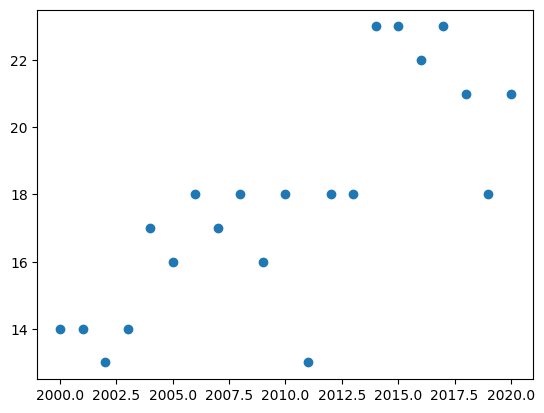

In [50]:
plt.scatter(
    YEARS,
    optimal_ks
)

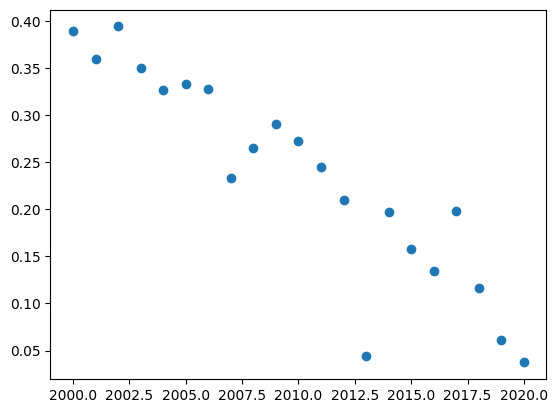

In [51]:
plt.scatter(
    YEARS,
    [optimal_k / num_paper for optimal_k, num_paper in zip(optimal_ks, num_papers)]
)

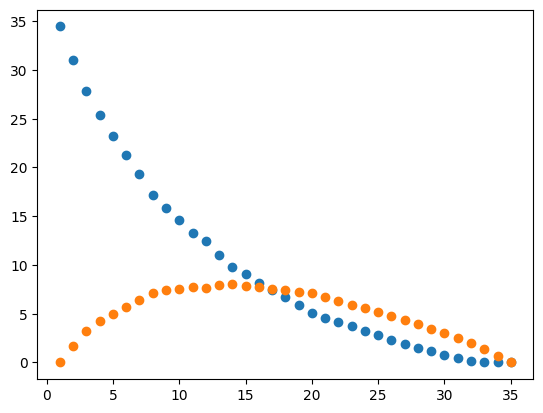

In [42]:
plt.scatter(ks, inertias)
plt.scatter(ks, distances)
plt.show()